<a href="https://colab.research.google.com/github/AbdoSabri99/BI_Project/blob/main/object_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Paths
ici nous avons créé notre espace de travail,een créant les dossiers et en important les données de training

In [ ]:
import os #import the operating system

In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
#here all the folders name that we will create during this notbook
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'IMAGE_TRAIN_PATH': os.path.join('Tensorflow', 'workspace','images','train'),
    'IMAGE_TEST_PATH': os.path.join('Tensorflow', 'workspace','images','test'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
#files we will create later
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
#create the folders
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

Télecharger le jeu de données hebergé au google drive

In [ ]:
!gdown --id "1-hLkaFRulYVnFOy0lEf4Hl4NixWYsRtK"
#!gdown --id "1TWEmhAM3gcSfX4S4N8ceSNBFPGqTCpKD"
!unzip ASAYAR_SIGN.zip

on deplace le jeu de données vers les dossiers  didier au images (le dossier `/content/Tensorflow/workspace/images') selon leurs types , test ou train

In [ ]:
!ls ASAYAR_SIGN/Test/Annotations/* | xargs -I{} mv {} /content/Tensorflow/workspace/images/test/
# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls ASAYAR_SIGN/Train/Annotations/* | xargs -I{} mv {} /content/Tensorflow/workspace/images/train/.
!ls ASAYAR_SIGN/Train/Images/* | xargs -I{} mv {} /content/Tensorflow/workspace/images/train/
!ls ASAYAR_SIGN/Test/Images/* | xargs -I{} mv {} /content/Tensorflow/workspace/images/test/
!rm -rf ASAYAR_SIGN.zip
!rm -rf ASAYAR_SYM.zip

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD
dans cette partie , nous allons profiter des modéles de detection des objetes en temps réels qui ont praitrainé sur des datasets similaires à la mienne.
nous avons choisi de travailer avec *ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8* qui est modéle trés connu, trainé et testé par la fameuse jeu de données coco.ci-aprés exmples des différents modéles pretrainés qui se trovent en Tensorflow Model Zoo
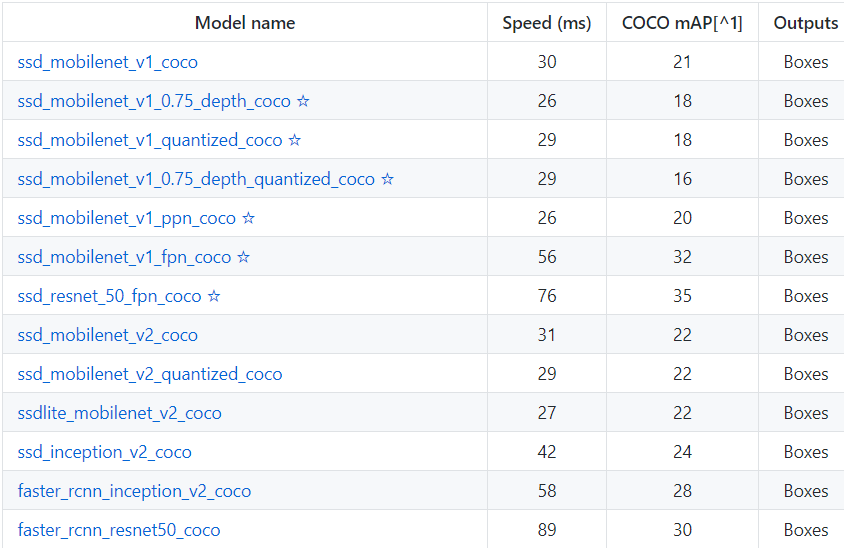

In [ ]:
#download the ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 model from the Tensorflow Model Zoo
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 69155, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 69155 (delta 1), reused 6 (delta 1), pack-reused 69147
Receiving objects: 100% (69155/69155), 577.28 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (48719/48719), done.


ici nous avons installé  Tensorflow Object Detection 

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda

ici on vérfie que notre decteur des objets qu'on vient d'installer opérationnel

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2022-02-16 21:10:57.794776: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0216 21:10:59.790220 140312928036736 model_builder.py:1100] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 3.72s
I0216 21:11:01.531581 140312928036736 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 3.72s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 2.3s
I0216 21:11:03.835340 140312928036736 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_cre

ici on tétécharge le modéle qu'on va utiliser et on le met dans un dossier applé pretrained_model


In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-02-16 17:34:17--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.69.128, 2607:f8b0:4001:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.69.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-02-16 17:34:17 (149 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/c

# 2. Create Label Map
TensorFlow nécessite une carte d'étiquettes, qui mappe chacune des étiquettes utilisées à des valeurs entières. Cette carte d'étiquettes est utilisée à la fois par les processus d'apprentissage et de détection.
Ci-dessous, nous montrons un exemple de carte d'étiquettes (par exemple label_map.pbtxt), en supposant que notre jeu de données contient 3 étiquettes, Regulatory_Sign,Warning_Sign et Guide_Sign :

In [ ]:
labels = [{'name':'Regulatory_Sign', 'id':1}, {'name':'Warning_Sign', 'id':2}, {'name':'Guide_Sign', 'id':3}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records
fichiers, qui contiennent la liste des annotations pour nos images de jeu de données.

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning
Habituellement, la formation d'un modèle de détection d'objets peut prendre plusieurs jours sur un CPU, mais l'apprentissage par transfert est une technique qui prend un modèle déjà formé pour une tâche connexe et l'utilise comme point de départ pour créer un nouveau modèle. En fonction de votre système et des paramètres d'entraînement, cela prend plutôt quelques heures ou moins. (Ce processus est parfois aussi appelé « fine-tuning » du modèle.)

In [ ]:
!pip uninstall numpy
!pip install numpy==1.20.0

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
#here the initial config of our mobileNet model
config

In [ ]:
#here we setup our own config
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

ici on choisit les hyperparametres de notre modele, c'est une étape trés critique , on doit choisir les bonnes paramétres pour obtenir les bonnes résultats

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 32
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=1700".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=1700


In [ ]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [ ]:
!{command}

2022-02-16 17:36:01.798764: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0216 17:36:01.812124 140188160628608 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 1700
I0216 17:36:01.821054 140188160628608 config_util.py:552] Maybe overwriting train_steps: 1700
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0216 17:36:01.821322 140188160628608 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0216 17:36:02.071234 140188160628608 deprecation.py:343] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
!{command}

W0216 19:05:52.286902 140549199505280 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0216 19:05:52.287225 140549199505280 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0216 19:05:52.287357 140549199505280 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0216 19:05:52.287501 140549199505280 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0216 19:05:52.287675 140549199505280 model_lib_v2.py:1111] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-02-16 19:05:52.942006: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original confi

# 8. Load Train Model From Checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
tf.config.run_functions_eagerly(True)

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-2')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [ ]:
!pip install "opencv-python-headless<4.3"

     |████████████████████████████████| 21.6 MB 2.9 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'image_1361.png')
#IMAGE_PATH = '/content/image_test.PNG'

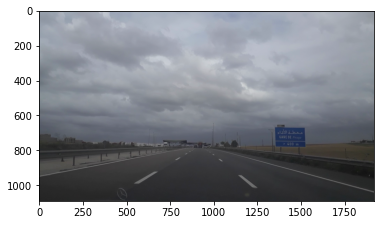

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# \# 10. Real Time Detections from video

In [ ]:
!gdown --id "1XbhP4e96RL52wVdfDUAlDKB5rD9be4FS"
import cv2
import numpy as np
cap = cv2.VideoCapture("testVid.mp4")
img_array = []
while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    img = image_np_with_detections
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)  

In [ ]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
#read the new video with detected sign
from IPython.display import HTML
from base64 import b64encode

video_path = '/content/project.avi'

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls><source src="{data_url}" type="video/mp4">
</video>""")